<a href="https://colab.research.google.com/github/omerfalach/Death-Classification-FAERS/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
!pip install squarify

     |████████████████████████████████| 82 kB 335 kB/s 


In [6]:
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import pytz
import pickle
# import pycountry_convert as pc
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import os
import warnings
import random
from sklearn.preprocessing import StandardScaler
import requests
from category_encoders import TargetEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, roc_auc_score, recall_score, accuracy_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc,precision_recall_curve,ConfusionMatrixDisplay
import project_plots as op
import plotly.express as px
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from datetime import datetime as dt

In [7]:
train_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_features1.csv')
test_features= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_features1.csv')
train_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_labels1.csv')
test_labels= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_labels1.csv')

In [8]:
##Defining functions for custom_preprocessors
##agecolumn - fill missing_values
class ageImputer(BaseEstimator, TransformerMixin) :
    def __init__(self, column = 'age'):
        self.death_chances = None
        self.live_chances = None
        self.column = column
        self.X1 = None
        self.y = None
    def get_age_new(self,d_chances,l_chances,column,out = -100):
        try:
            out = int(out)
            if out == 1:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(d_chances['age_groups'])]
                death_ages = random.choices(ages_unichoi, weights = list(d_chances[column]), k = 1)
                return round(death_ages[0], 1)
            elif out==0:
                ages_unichoi = [random.uniform(i.left,i.right) for i in list(l_chances['age_groups'])]
                live_ages = random.choices(ages_unichoi, weights = list(l_chances[column]), k = 1)
                return round(live_ages[0], 1)
            else:
                trans = random.choices(random.uniform(i.left,i.right), weights = list(d_chances[column]), k = 1)
                return  round(trans[0], 1)
        except:
            return -1

    def fit(self, X, y=None):
        self.y = y
        self.X1 = X.merge(self.y, right_index=True, left_index=True)
        X_fixed_age_not_null = self.X1[self.X1[self.column].notnull()]
        death = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==1]
        live = X_fixed_age_not_null[X_fixed_age_not_null['outc_cod']==0]
        self.death_chances = death[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.death_chances = self.death_chances.reset_index().rename(columns = {'index':'age_groups'})
        self.live_chances = live[self.column].value_counts(bins= 2 ,normalize = True).to_frame()
        self.live_chances =self.live_chances.reset_index().rename(columns = {'index':'age_groups'})
        self.X1[self.column] = self.X1.apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column,row['outc_cod']) if np.isnan(row[self.column]) else row[self.column],axis=1)
        X.iloc[:, 0] = self.X1[self.column]
        return  self                      
    def transform(self, X, y=None):
        X1 = X.copy()
        X1.iloc[:, 0] = X1.iloc[:, 0].apply(lambda row: self.get_age_new(self.death_chances,self.live_chances,self.column) if np.isnan(row) else row)
        return X1
###convert_sex_values_to_integer_and_fillna_randomaly
def sex_change(x):
    if x =='M':
        return 0
    elif x == 'F':
        return 1
    else:
        return random.choice([0,1])
def sex_transform_to_pipe(data):
    z = data.apply(lambda x: [sex_change(t) for t in x])
    return z
def convert_df_column_to_list(data):
    d = list(data.iloc[:, 0])
    return d

In [9]:
drug_feature = ['drugname_listed']
age_feature = ['age']
sex_feature = ['sex']
cat_features = ['occr_country']
indi_feature = ['indi_pt']
catall_features = ['drugname','occr_country']
all_features = ['age','sex','drugname','occr_country']
sex_transformer = Pipeline(steps=[('se',FunctionTransformer(sex_transform_to_pipe))])
target_encoding_transformer = Pipeline(steps = [('target',TargetEncoder())])
tfidf_transformer=  Pipeline(steps=[
    ('extract_list',FunctionTransformer(convert_df_column_to_list,validate=False)),
    ('tf',TfidfVectorizer(analyzer = 'word',tokenizer=lambda x: x,
                        preprocessor=lambda x: x,lowercase = False))])
ageImputer_transformer = Pipeline(steps = 
    [("age", ageImputer()),
        ('scale', StandardScaler())])
drug_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('drug',tfidf_transformer,drug_feature),
    ('categorical',target_encoding_transformer,cat_features)
])
indi_tf_idf_preprocessor =ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age2',ageImputer_transformer,age_feature),
    ('indi',tfidf_transformer,indi_feature),
    ('categorical',target_encoding_transformer,cat_features)
])
baseline_preprocessor = ColumnTransformer(transformers = [
    ('sex',sex_transformer,sex_feature),
    ('age',ageImputer_transformer,age_feature),
    ('categorical',target_encoding_transformer,catall_features)])

In [10]:
class set_modeling():
    def __init__(self, num_val_folds = 5):
        #Initialze the general parameters
        self.score_to_optimize = 'AUC'
        self.verbose = 10
        self.n_experiments = int(1e1)
        self.n_jobs=-2 
        self.num_val_folds = num_val_folds
        self.splitter = StratifiedKFold(self.num_val_folds)
        #Initiaze scorers
        self.auc_scorer = None
        self.precision_scorer = None
        self.recall_scorer = None
        self.precision_recall_scorer = None
        self.scorers = dict
        self.hyper_opt = None 
    ##get roc_auc_score
    def get_roc_auc(self,gt, pred):
        return roc_auc_score(gt, pred, average='weighted')
    def get_precision(self,gt, pred):
        return precision_score(gt, pred, average='weighted')
    def get_recall(self,gt, pred):
        return recall_score(gt, pred, average='weighted')
    def get_precision_recall_fscore_support(self,gt, pred):
        precision,recall,f2_score,support = precision_recall_fscore_support(gt, pred,beta = 2,average='weighted')
        return f2_score
    def set_scorers(self):
        self.auc_scorer = make_scorer(self.get_roc_auc, needs_proba=True)
        self.precision_scorer = make_scorer(self.get_precision)
        self.recall_scorer = make_scorer(self.get_recall)
        self.precision_recall_scorer = make_scorer(self.get_precision_recall_fscore_support)
        self.scorers = {'AUC':  self.auc_scorer, 
           'Precision': self.precision_scorer, 'Recall': self.recall_scorer,
           'Accuracy': 'accuracy'}
    def optimize_predict(self,train_features, train_labels,test_features,test_labels,pipeline,param):
        print(type(train_labels[0:10]))
        self.set_scorers()
        self.hyper_opt = RandomizedSearchCV(pipeline, param,n_iter = self.n_experiments,
                           scoring = self.scorers, n_jobs =  self.n_jobs, cv=self.splitter,
                           refit=self.score_to_optimize,pre_dispatch =2,
                           return_train_score=False, verbose=self.verbose)
        tr_val_sequences, tr_val_labels = train_features, train_labels
        num_label_apperances = tr_val_labels.value_counts()
        min_label_apperances = min(num_label_apperances)
        if self.num_val_folds > min_label_apperances:
            self.hyper_opt.cv = StratifiedKFold(min_label_apperances)
        start_time = dt.now()
        print(f"Fitting (training) the models and performing hyper parameter search. "
              f"Time: {start_time}")
        self.hyper_opt.fit(tr_val_sequences, tr_val_labels)
        best_ind = self.hyper_opt.best_index_
        scores = {}
        for scorer in self.scorers:
            scores[scorer] = self.hyper_opt.cv_results_['mean_test_' + scorer][best_ind]
        scores_str = '\n'.join(f"{k}: {v:.3f}" for k, v in scores.items())
        print(f'---Algorithm performance---: \n{scores_str}\n-------------')

        ##Prediction
        # def get_results(modelt,test_features,test_labels)
        # y_predict = modelt.predict(test_features)
        # y_scores = modelt.predict_proba(test_features)[:, 1]
        # fpr, tpr, thresholds =roc_curve(test_labels, y_scores)
        # precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
        # auc = roc_auc_score(test_labels, y_scores)
        # fig, axes = plt.subplots(1,2, figsize = (20,10))
        # pre_rec(recall, precision,ax = axes[0])
        # plot_roc(fpr, tpr,auc,ax = axes[1])
        # cm_plot(modelt,test_features,test_labels)
        y_predict = self.hyper_opt.predict(test_features)
        y_scores = self.hyper_opt.predict_proba(test_features)[:, 1]
        fpr, tpr, thresholds =roc_curve(test_labels, y_scores)
        precision, recall, thresholds = precision_recall_curve(test_labels, y_scores)
        auc = roc_auc_score(test_labels, y_scores)
        fig, axes = plt.subplots(1,2, figsize = (20,10))
        op.pre_rec(recall, precision,ax = axes[0])
        op.plot_roc(fpr, tpr,auc,ax = axes[1])
        op.cm_plot(self.hyper_opt,test_features,test_labels)
        end_time = dt.now()
        duration = (end_time - start_time).total_seconds()
        print(f'Training took {duration} seconds')


In [11]:
class pipes_training(set_modeling):
        def __init__(self, preprocessor = None,num_val_folds = 5):
            set_modeling.__init__(self)
            self.reg_coef_logrange = (0, 3, 5)
            self.min_dfs_logrange = (0, 2, 1)
            # Initialze featuers
            self.drug_feature = ['drugname']
            self.age_feature = ['age']
            self.sex_feature = ['sex']
            self.cat_features = ['occr_country']
            self.catall_features = ['drugname','occr_country']
            self.naive_preprocessor = preprocessor
            # Initialze the estimators
            self.clf1 = LogisticRegression()
            self.clf2 = RandomForestClassifier()
            # self.clf3 = KNeighborsClassifier()
            # self.classifiers = [self.clf1,self.clf2]
            self.classifiers = [self.clf2]
            self.models = []
            # Initiaze dictionaries for hyperparameters
            self.param1 = {}
            self.param2 = {}
            self.param3 = {}
            self.params = {}
        def log_range(self,lower, upper, samples_per_decade, is_int=True):
            samples = 1 + (upper - lower) * samples_per_decade
            samples = int(round(samples))
            if is_int:
                return [int(round(i)) for i in np.logspace(lower, upper, samples)]
            else:
                return list(np.logspace(lower, upper, samples))
        def set_hyperparameters(self): #hyperparameters for each classifier
            ##fill logistic regression parameters
            self.param1['feature_extractor']= self.naive_preprocessor
            # self.param1['feature_extractor__indi__tf__min_df']= [0.01,0.05,0.1]
            self.param1['feature_extractor__categorical__target__min_samples_leaf']= [200,1000,2000]
            self.param1['classifier__solver']=['lbfgs']
            self.param1['classifier__multi_class']=['auto']
            self.param1['classifier__max_iter']=[int(1e6)]
            self.param1['classifier__class_weight']=['balanced']
            self.param1['classifier__C'] = self.log_range(*self.reg_coef_logrange, is_int=False)
#             self.param1['classifier__penalty'] = ['l1', 'l2']
            self.param1['classifier'] = [self.clf1]

             ##fill randomforest parameters
            self.param2['feature_extractor__categorical__target__min_samples_leaf']= [200,1000]
            self.param2['feature_extractor']=self.naive_preprocessor
            self.param2['classifier__n_estimators'] = [10]
            self.param2['classifier__max_depth'] = [5, 10, 20]
            self.param2['classifier__class_weight'] = ['balanced_subsample']
            self.param2['classifier'] = [self.clf2]

            ##fill knn parameters
            self.param3['feature_extractor']=[naive_preprocessor],
            self.param3['classifier__n_neighbors'] = [5,10,25,50]
            self.param3['classifier'] = [self.clf3]
            self.params = [self.param1,self.param2,self.param3]
        def add_params(self,new_params):
          self.params.append(new_params)
        def train_pipes(self,train_features, train_labels,test_features,test_labels,default_params = True,params = 0):
                if default_params ==True:
                    self.set_hyperparameters()
                params_for_tuning = self.params[params]
                for i in self.classifiers:
                    print(i)
                    p = Pipeline(steps = [('feature_extractor','passthrough'),('classifier',i)])
#                     print(p)
                    self.optimize_predict(train_features, train_labels,test_features,test_labels,p, params_for_tuning)
                    self.models.append(self.hyper_opt)
                return self.models

---Algorithm performance---: 
AUC: 0.727
Precision: 0.813
Recall: 0.748
Accuracy: 0.748
-------------


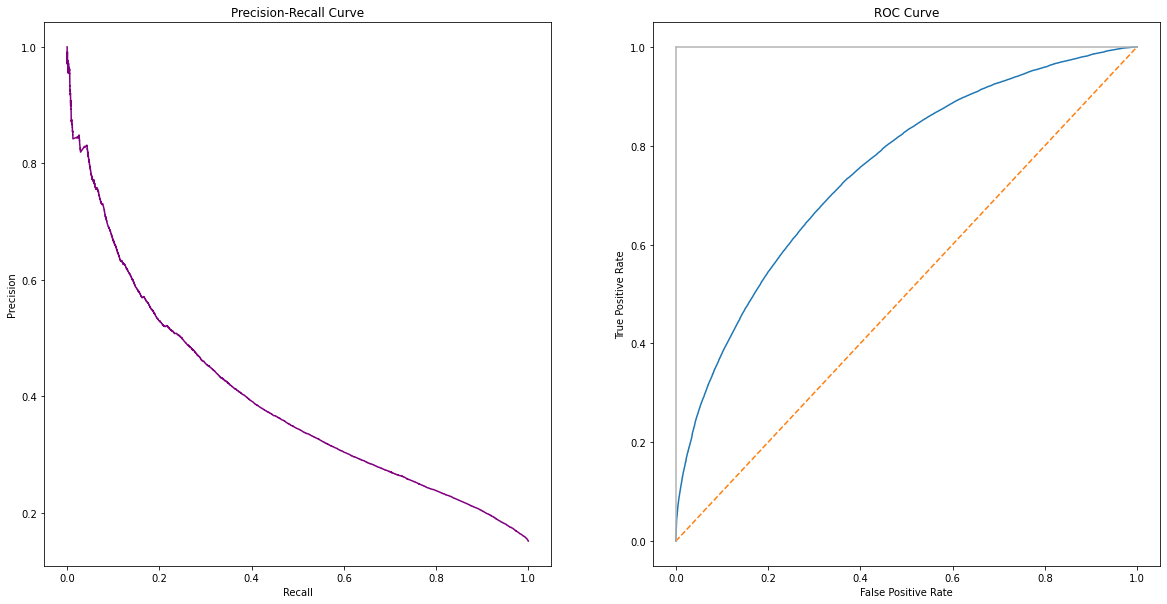

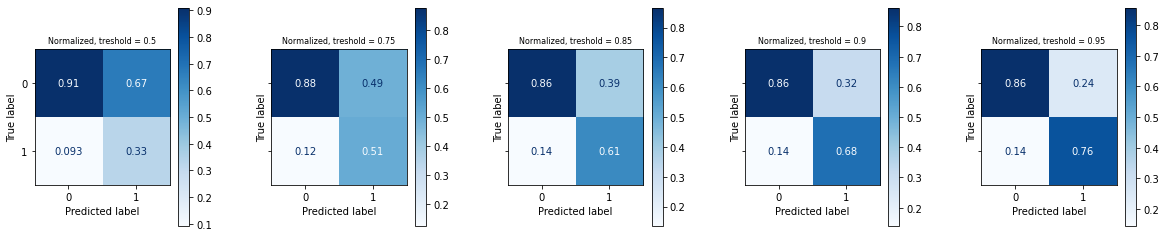

In [13]:
import dill as pickle
import project_plots as op
##Training - Baseline model_10Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor = [baseline_preprocessor],num_val_folds=10)
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/baseline_traget_encoding_Logistic_Regression.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
baseline_logreg = pickle.load(open(filename, 'rb'))
op.get_results(baseline_logreg,test_features,test_labels)

---Algorithm performance---: 
AUC: 0.742
Precision: 0.820
Recall: 0.706
Accuracy: 0.706
-------------


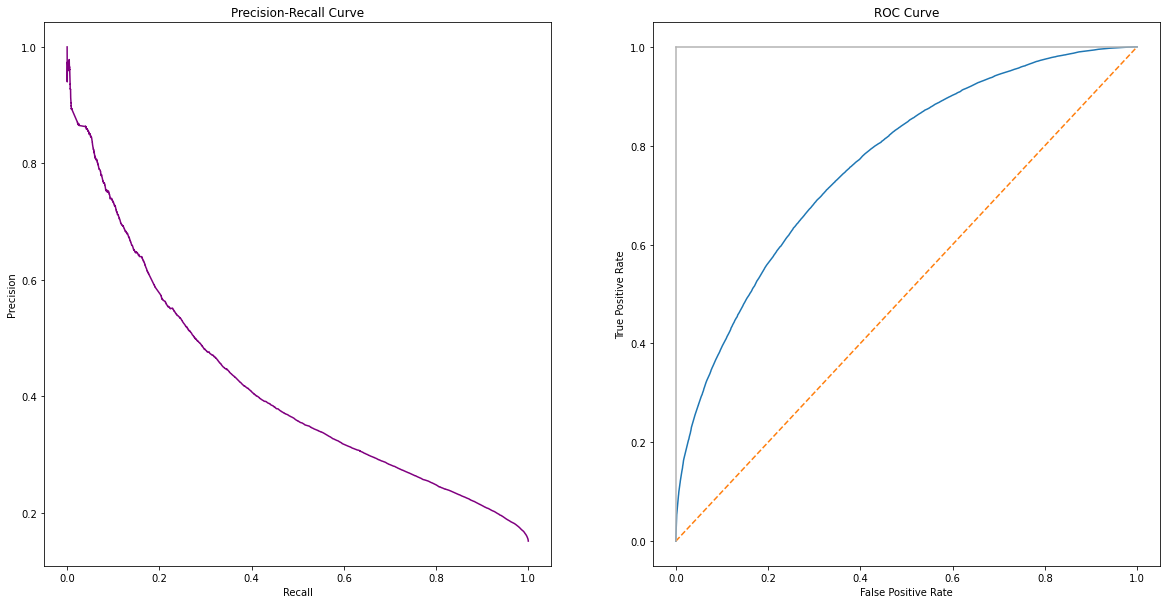

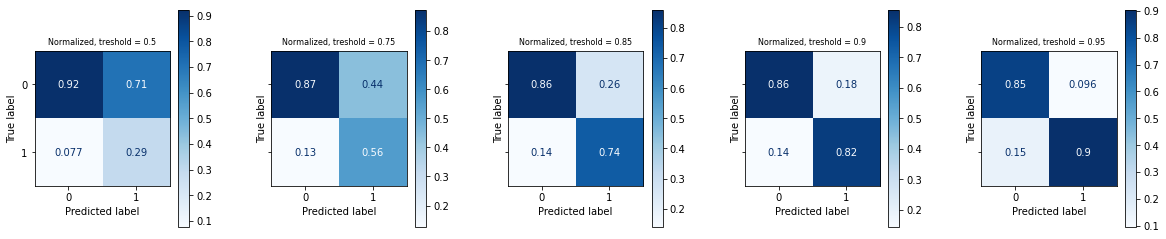

In [14]:
##Training - Baseline model_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor = [baseline_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/baseline_traget_encoding_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
baseline_rforest = pickle.load(open(filename, 'rb'))
op.get_results(baseline_rforest,test_features,test_labels)

---Algorithm performance---: 
AUC: 0.618
Precision: 0.780
Recall: 0.708
Accuracy: 0.708
-------------


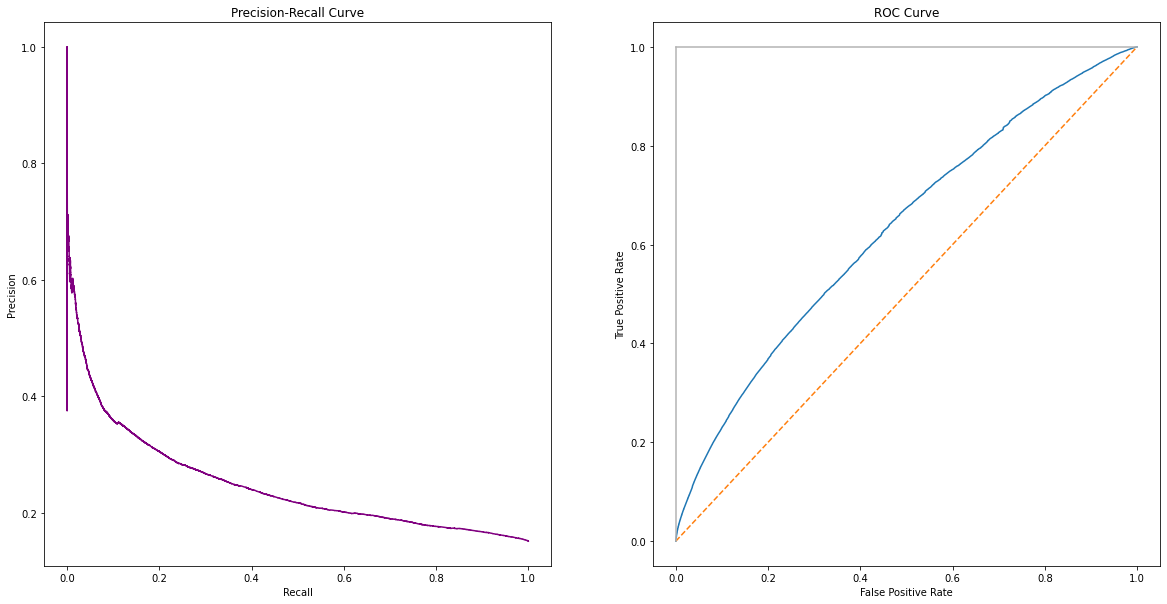

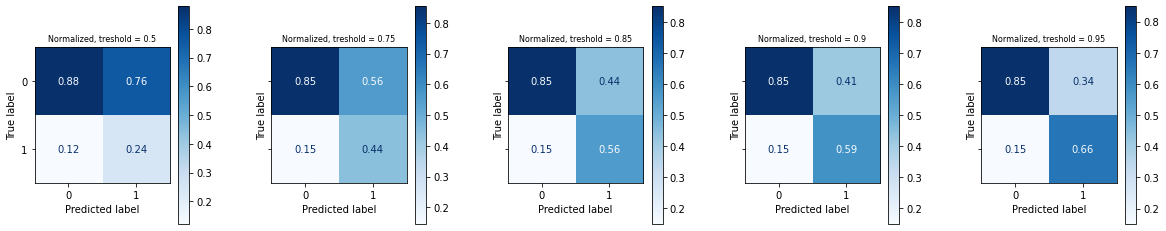

In [15]:
##Training - Using_tf-idf_vectorizer_for_drugname_feature_5Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_Logistic_Regression.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_tfidf_logreg = pickle.load(open(filename, 'rb'))
op.get_results(drug_tfidf_logreg,test_features,test_labels)

---Algorithm performance---: 
AUC: 0.733
Precision: 0.815
Recall: 0.779
Accuracy: 0.779
-------------


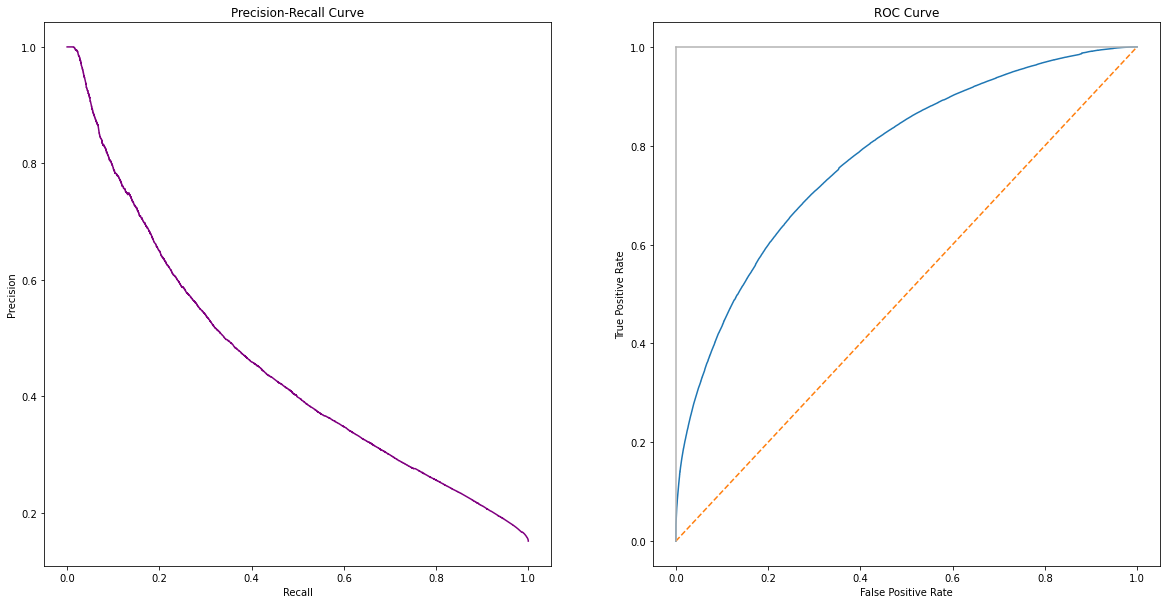

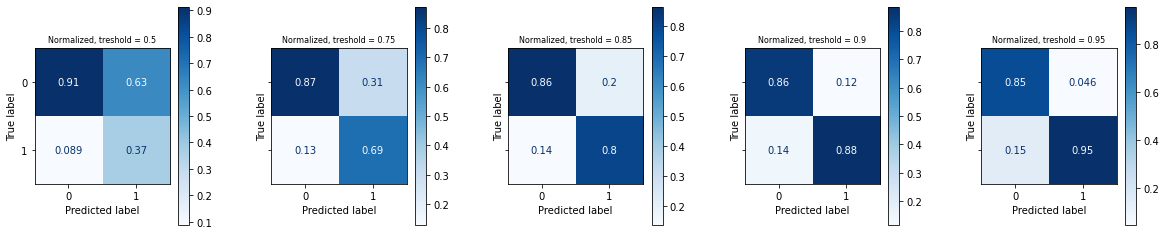

In [21]:
##Training - Using_tf-idf_vectorizer_for_drugname_feature_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_tfidf_rforest = pickle.load(open(filename, 'rb'))
op.get_results(drug_tfidf_rforest,test_features,test_labels)

---Algorithm performance---: 
AUC: 0.667
Precision: 0.789
Recall: 0.708
Accuracy: 0.708
-------------


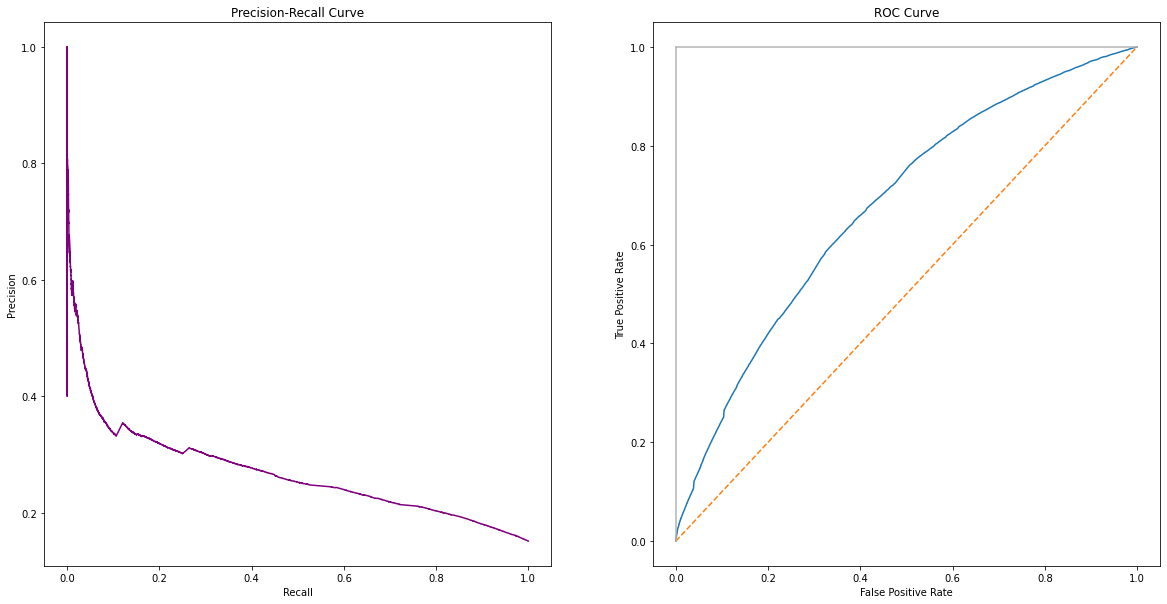

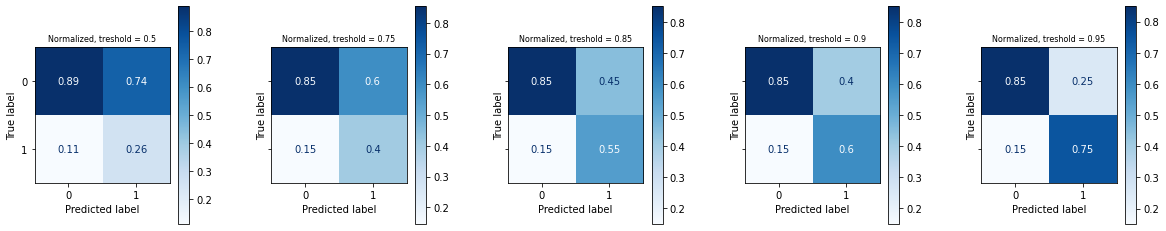

In [23]:
##Training - Using_tf-idf_vectorizer_for_indi_pt_feature_5Folds
##Logistic_Regression
# baseline = pipes_training(preprocessor =[indi_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/indi_tf_idf_Logistic_Regression.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
indi_tfidf_logreg = pickle.load(open(filename, 'rb'))
op.get_results(indi_tfidf_logreg,test_features,test_labels)

---Algorithm performance---: 
AUC: 0.744
Precision: 0.817
Recall: 0.745
Accuracy: 0.745
-------------


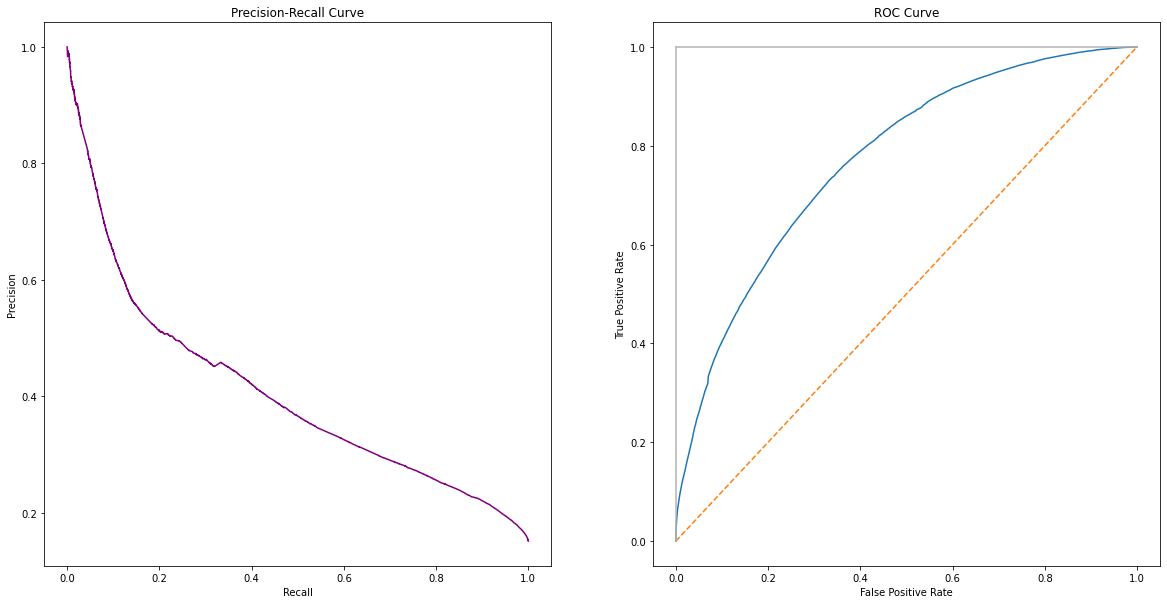

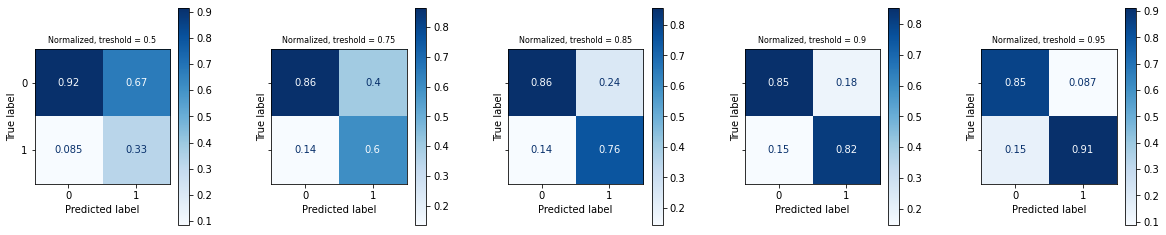

In [26]:
##Training - Using_tf-idf_vectorizer_for_indi_pt_feature_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor =[indi_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/indi_tf_idf_Random_Forest.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
indi_tfidf_rforest = pickle.load(open(filename, 'rb'))
op.get_results(indi_tfidf_rforest,test_features,test_labels)


In [ ]:
##Training - Using_weighted_tf-idf_vectorizer_for_drugname_feature_5Folds
##Logistic_Regression
baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'])
filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_Logistic_Regression.pkl'
pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_weighted_tfidf_logreg = pickle.load(open(filename, 'rb'))
op.get_results(drug_weighted_tfidf_logreg,test_features,test_labels)

In [20]:
##Training - Using_weigthed_tf-idf_vectorizer_for_drugname_feature_5Folds
##Random_Forest
# baseline = pipes_training(preprocessor =[drug_tf_idf_preprocessor])
# models = baseline.train_pipes(train_features,train_labels['outc_cod'],test_features,test_labels['outc_cod'],params=1)
filename = '/content/drive/MyDrive/Colab Notebooks/drug_tf_idf_weighted_random_forest_gpu.pkl'
# pickle.dump(models[0], open(filename, 'wb'))
###Results
drug_weighted_tfidf_rforest = pickle.load(open(filename, 'rb'))
op.get_resultsplot(drug_weighted_tfidf_rforest,test_features,test_labels)

FileNotFoundError: ignored